In [1]:
# import the necessary libraries
import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.neighbors import KNeighborsRegressor

# Get the data

First, we import CSV files for our data from 2008-2016 that we created from our webscraping and cleaning during the initial eda/baseline phase of our project. 

In [2]:
df_2016 = pd.read_csv(r'newdata/2016eda.csv')
df_2012 = pd.read_csv(r'newdata/2012eda.csv')
df_2008 = pd.read_csv(r'newdata/2008eda.csv')

df_2012.head()

,Unnamed: 0,state,November_poll,October_poll,September_poll,August_poll,July_poll,June_poll,May_poll,April_poll,March_poll,total_votes,dem_votes,dem_%,dem_ev,rep_votes,rep_%,rep_ev
0,0,Arizona,43.743153,42.783595,41.820886,41.355177,41.780028,42.128162,41.433218,41.101501,41.103824,2573165,1161167,45.1,NaN,1252401,48.7%,11.0
1,1,Arkansas,32.926574,33.326509,33.339458,32.823809,32.802314,32.817970,32.818227,32.829684,32.848762,1130635,380494,33.7,NaN,684872,60.6%,6.0
2,2,California,54.869049,55.076109,54.903553,53.955389,54.239653,55.030262,57.154549,58.325194,55.648025,14181595,8753788,61.7,55.0,4483810,31.6%,NaN
3,3,Colorado,47.959072,47.681597,47.610872,46.419814,46.633025,47.161007,48.351758,48.621831,46.557553,2780220,1338870,48.2,9.0,1202484,43.3%,NaN
4,4,Connecticut,53.482189,52.556660,51.946074,51.066988,51.397533,51.556683,52.899047,52.869640,52.895190,1644920,897572,54.6,7.0,673215,40.9%,NaN


Now, we import the 2020 polling data which we downloaded from https://projects.fivethirtyeight.com

In [3]:
df = pd.read_csv(r'newdata/president_polls.csv')
df.columns

/Users/stevenmorse/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6,22,25,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['question_id', 'poll_id', 'cycle', 'state', 'pollster_id', 'pollster',
       'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id',
       'pollster_rating_name', 'fte_grade', 'sample_size', 'population',
       'population_full', 'methodology', 'office_type', 'seat_number',
       'seat_name', 'start_date', 'end_date', 'election_date',
       'sponsor_candidate', 'internal', 'partisan', 'tracking',
       'nationwide_batch', 'ranked_choice_reallocated', 'created_at', 'notes',
       'url', 'stage', 'race_id', 'answer', 'candidate_id', 'candidate_name',
       'candidate_party', 'pct'],
      dtype='object')

In [4]:
df.head()

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,...,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content...,general,6223,Biden,13256,Joseph R. Biden Jr.,DEM,49.0
1,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,...,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content...,general,6223,Trump,13254,Donald Trump,REP,48.0
2,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Biden,13256,Joseph R. Biden Jr.,DEM,48.4
3,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Trump,13254,Donald Trump,REP,49.2
4,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Jorgensen,14611,Jo Jorgensen,LIB,1.4


# Clean 2020 Data

In [5]:
#Only for Trump and Biden
df = df.loc[((df.answer == "Biden") | (df.answer == "Trump"))] 

In [6]:
#split up time 
df['month'] = pd.DatetimeIndex(df['created_at']).month     
df['year'] = pd.DatetimeIndex(df['created_at']).year  

In [7]:
#and drop any with polls from before 2020
df = df.loc[df.year == 2020]

In [8]:
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [9]:
# Here is where I cut down the columns but feel free to change/add more
df_2020 = df[["state", "month","candidate_name", "pct"]]

df_2020.head()

,state,month,candidate_name,pct
0,Iowa,11,Joseph R. Biden Jr.,49.0
1,Iowa,11,Donald Trump,48.0
2,Pennsylvania,11,Joseph R. Biden Jr.,48.4
3,Pennsylvania,11,Donald Trump,49.2
5,Florida,11,Joseph R. Biden Jr.,47.0


# We realized through the process above we needed new, more robust and focused data for both train and test date (previous years and this year) 

We chose to focus our predictions based on key battleground states. In other words, we will be assuming that the election results in all states other than these eight swing states we have chosen are already decided, as they tend not to swing between party lines. We will observe the relationship between polling trends and election results in these eight states over the course of three election years (2008, 2012 and 2016) in order to predict the outcome of the 2020 election. This data was pulled from RealClearPolitics. We leveraged Wayback Machine to get  the 2008 through 2016 results that were no longer accessible through the live site. Note that as we developed our model we determined that we wanted to weight the 2016 year higher. To this end, we replicated the occurences of the 2016 data twice over in all of these csvs. The csv's without the 2 at the end do not have the additional copies of the 2016 polls. 

In [10]:
arizona = pd.read_csv('statepolls/arizona2.csv')
florida = pd.read_csv('statepolls/florida2.csv')
georgia = pd.read_csv('statepolls/georgia2.csv')
michigan = pd.read_csv('statepolls/michigan2.csv')
nevada = pd.read_csv('statepolls/nevada2.csv')
north_carolina = pd.read_csv('statepolls/north_carolina2.csv')
pennsylvania = pd.read_csv('statepolls/pennsylvania2.csv')
wisconsin= pd.read_csv('statepolls/wisconsin2.csv')

In [11]:
#put them in a list so we can iterate through them 
swing_states = [arizona, florida, georgia, michigan, nevada, north_carolina, pennsylvania, wisconsin]
election_years = ['2008', '2012', '2016', '2020']

*Here we reorganize the data to get the columns we want. For clarification, LV is likely to vote, RV is registered to vote.*

In [12]:
#Now let's iterate!!
for state_df in swing_states:
    state_df['binary_d1_r0'] = 0
    state_df['Margin'] = 0
    state_df['LV'] = 0
    state_df['RV'] = 0
    state_df['start_date'] = 0
    state_df['end_date'] = 0
    state_df['sample_size'] = 0
    

    #need to do this for each state
    for ind in state_df.index:
        #clean MoE
        if state_df['MoE'][ind] == '--':
            state_df['MoE'][ind] = 3
            
        if state_df['D'][ind] > state_df['R'][ind]:
            state_df['binary_d1_r0'][ind] = 1

        #Add difference
        dem_margin = state_df['D'][ind] - state_df['R'][ind]
        state_df['Margin'][ind] = dem_margin

        #get LV or RV
        lv_rv = state_df['Sample'][ind][-2:]
        if lv_rv == 'LV':
            state_df['LV'][ind] = 1
        if lv_rv == 'RV':
            state_df['RV'][ind] = 1

        #split the dates
        start_date = state_df['Date'][ind].rsplit(' ', -1)[0]
        end_date = state_df['Date'][ind].rsplit(' ', 1)[1]
        state_df['start_date'][ind] = start_date
        state_df['end_date'][ind] = end_date

        #add sample
        sample_size = state_df['Sample'][ind].rsplit(' ', -1)[0]
        state_df['sample_size'][ind] = sample_size

<ipython-input-12-35c93e53d3e1>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['Margin'][ind] = dem_margin
<ipython-input-12-35c93e53d3e1>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['LV'][ind] = 1
<ipython-input-12-35c93e53d3e1>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['start_date'][ind] = start_date
/Users/stevenmorse/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: S

*Here, we split it up by year so it is easier to split into test and train data later. For some reason, it just didn't work to iterate over everything so we did it individually.*

In [13]:
#one-hot encode year
# for state_df in swing_states:
#     years = pd.get_dummies(state_df['year'], prefix='')
#     state_df = pd.concat([state_df, years], axis=1, sort=False)

years = pd.get_dummies(florida.year, prefix='')
florida = pd.concat([florida, years], axis=1, sort=False)

years = pd.get_dummies(arizona.year, prefix='')
arizona = pd.concat([arizona, years], axis=1, sort=False)

years = pd.get_dummies(georgia.year, prefix='')
georgia = pd.concat([georgia, years], axis=1, sort=False)

years = pd.get_dummies(michigan.year, prefix='')
michigan = pd.concat([michigan, years], axis=1, sort=False)

years = pd.get_dummies(nevada.year, prefix='')
nevada = pd.concat([nevada, years], axis=1, sort=False)

years = pd.get_dummies(north_carolina.year, prefix='')
north_carolina = pd.concat([north_carolina, years], axis=1, sort=False)

years = pd.get_dummies(pennsylvania.year, prefix='')
pennsylvania = pd.concat([pennsylvania, years], axis=1, sort=False)

years = pd.get_dummies(wisconsin.year, prefix='')
wisconsin = pd.concat([wisconsin, years], axis=1, sort=False)

In [14]:
swing_states = [arizona, florida, georgia, michigan, nevada, north_carolina, pennsylvania, wisconsin]
swing_states[1].head()

,Poll,Date,Sample,MoE,D,R,Spread,year,state,binary_d1_r0,Margin,LV,RV,start_date,end_date,sample_size,_2008,_2012,_2016,_2020
0,FOX 35/InsiderAdvantage*,11/2 - 11/2,400 LV,4.4,47,48,Trump +1,2020,florida,0,-1,1,0,11/2,11/2,400,0,0,0,1
1,Trafalgar Group (R)*,10/31 - 11/2,1003 LV,2.9,47,49,Trump +2,2020,florida,0,-2,1,0,10/31,11/2,1003,0,0,0,1
2,CNBC/Change Research (D),10/29 - 11/1,806 LV,3,51,48,Biden +3,2020,florida,1,3,1,0,10/29,11/1,806,0,0,0,1
3,Susquehanna*,10/29 - 11/1,400 LV,4.9,46,47,Trump +1,2020,florida,0,-1,1,0,10/29,11/1,400,0,0,0,1
4,Rasmussen Reports,10/29 - 10/31,800 LV,3.5,48,47,Biden +1,2020,florida,1,1,1,0,10/29,10/31,800,0,0,0,1


*Now we are going to convert dates to days before election so it has more numerical agency*

In [15]:
#first let's add election date column
for state_df in swing_states:
    state_df['election_date'] = 0
    state_df['start_month'] = 0
    state_df['start_day'] = 0
    state_df['end_month'] = 0
    state_df['end_day'] = 0
    
    #df["period"] = df["Year"] + df["quarter"]
    
    for ind in state_df.index:
        
        state_df['start_month'][ind] = state_df['start_date'][ind].rsplit('/', -1)[0]
        state_df['start_day'][ind] = state_df['start_date'][ind].rsplit('/', 1)[1]
        state_df['end_month'][ind] = state_df['end_date'][ind].rsplit('/', -1)[0]
        state_df['end_day'][ind] = state_df['end_date'][ind].rsplit('/', 1)[1]
    
        if state_df['_2008'][ind] == 1:
            state_df['election_date'][ind] = '11/04/2008' #might need to do .astype datetime or whatever

        if state_df['_2012'][ind] == 1:
            state_df['election_date'][ind] = '11/06/2012'

        if state_df['_2016'][ind] == 1:
            state_df['election_date'][ind] = '11/08/2016'

        if state_df['_2020'][ind] == 1:
            state_df['election_date'][ind] = '11/03/2020'
            
    state_df['election_date'] = pd.to_datetime(state_df['election_date'])
            
    state_df['end_datetime'] = pd.to_datetime(dict(year=state_df.year, month=state_df.end_month, day=state_df.end_day))
    state_df['start_datetime'] = pd.to_datetime(dict(year=state_df.year, month=state_df.start_month, day=state_df.start_day))
    
    state_df['DAYS_TO'] = state_df['election_date'] - state_df['end_datetime']
    state_df['POLL_LENGTH'] = state_df['end_datetime'] - state_df['start_datetime']

    for ind in state_df.index:
        state_df['DAYS_TO'][ind] = state_df['DAYS_TO'][ind].days
        state_df['POLL_LENGTH'][ind] = state_df['POLL_LENGTH'][ind].days
    
    state_df = state_df[(state_df[['DAYS_TO']] > 0).all(1)]

<ipython-input-15-f68867f769b1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['start_month'][ind] = state_df['start_date'][ind].rsplit('/', -1)[0]
<ipython-input-15-f68867f769b1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['start_day'][ind] = state_df['start_date'][ind].rsplit('/', 1)[1]
<ipython-input-15-f68867f769b1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['end_month'][ind] = state_df['e

*Let's scroll through one state, say Florida, and make sure it's all peachy keen.*

In [16]:
#dates still aren't working correctly (getting lots of weird negatives) need to add 365 to some, need to fix reference year on others. 
florida

,Poll,Date,Sample,MoE,D,R,Spread,year,state,binary_d1_r0,Margin,LV,RV,start_date,end_date,sample_size,_2008,_2012,_2016,_2020,election_date,start_month,start_day,end_month,end_day,end_datetime,start_datetime,DAYS_TO,POLL_LENGTH
0,FOX 35/InsiderAdvantage*,11/2 - 11/2,400 LV,4.4,47,48,Trump +1,2020,florida,0,-1,1,0,11/2,11/2,400,0,0,0,1,2020-11-03,11,2,11,2,2020-11-02,2020-11-02,1,0
1,Trafalgar Group (R)*,10/31 - 11/2,1003 LV,2.9,47,49,Trump +2,2020,florida,0,-2,1,0,10/31,11/2,1003,0,0,0,1,2020-11-03,10,31,11,2,2020-11-02,2020-10-31,1,2
2,CNBC/Change Research (D),10/29 - 11/1,806 LV,3,51,48,Biden +3,2020,florida,1,3,1,0,10/29,11/1,806,0,0,0,1,2020-11-03,10,29,11,1,2020-11-01,2020-10-29,2,3
3,Susquehanna*,10/29 - 11/1,400 LV,4.9,46,47,Trump +1,2020,florida,0,-1,1,0,10/29,11/1,400,0,0,0,1,2020-11-03,10,29,11,1,2020-11-01,2020-10-29,2,3
4,Rasmussen Reports,10/29 - 10/31,800 LV,3.5,48,47,Biden +1,2020,florida,1,1,1,0,10/29,10/31,800,0,0,0,1,2020-11-03,10,29,10,31,2020-10-31,2020-10-29,3,2
5,Quinnipiac,10/28 - 11/1,1657 LV,2.4,47,42,Biden +5,2020,florida,1,5,1,0,10/28,11/1,1657,0,0,0,1,2020-11-03,10,28,11,1,2020-11-01,2020-10-28,2,4
6,St. Pete Polls,10/29 - 10/30,2758 LV,1.9,49,48,Biden +1,2020,florida,1,1,1,0,10/29,10/30,2758,0,0,0,1,2020-11-03,10,29,10,30,2020-10-30,2020-10-29,4,1
7,Reuters/Ipsos,10/27 - 11/1,610 LV,5,50,46,Biden +4,2020,florida,1,4,1,0,10/27,11/1,610,0,0,0,1,2020-11-03,10,27,11,1,2020-11-01,2020-10-27,2,5
8,NY Times/Siena*,10/27 - 10/31,1451 LV,3.2,47,44,Biden +3,2020,florida,1,3,1,0,10/27,10/31,1451,0,0,0,1,2020-11-03,10,27,10,31,2020-10-31,2020-10-27,3,4
9,Emerson,10/29 - 10/30,849 LV,3.3,51,45,Biden +6,2020,florida,1,6,1,0,10/29,10/30,849,0,0,0,1,2020-11-03,10,29,10,30,2020-10-30,2020-10-29,4,1


*We want our y values to be election margins so we are going to upload the appropriate data and add it to our data set to make x and y the same length. Election margins were pulled from the New York Times' records. 

In [17]:
#get election margins
election_margins = pd.read_csv(r'statepolls/election_margins.csv')
election_margins_2008 = pd.DataFrame(election_margins[(election_margins['year'] == 2008)])
election_margins_2012 = pd.DataFrame(election_margins[(election_margins['year'] == 2012)])
election_margins_2016 = pd.DataFrame(election_margins[(election_margins['year'] == 2016)])
election_margins_2020 = pd.DataFrame(election_margins[(election_margins['year'] == 2020)])

In [18]:
election_margins_2008

,state,year,margin_perc
24,arizona,2008,-9.0
25,florida,2008,3.0
26,georgia,2008,-5.0
27,michigan,2008,16.0
28,nevada,2008,12.0
29,north_carolina,2008,0.0
30,pennsylvania,2008,11.0
31,wisconsin,2008,14.0


In [19]:
state = 'florida'
margin = election_margins_2008[(election_margins_2008['state'] == state)]['margin_perc'].values
float(margin)

3.0

In [20]:
election_margins_2020

,state,year,margin_perc
0,arizona,2020,0.30
1,florida,2020,-3.30
2,georgia,2020,0.24
3,michigan,2020,2.80
4,nevada,2020,2.40
5,north_carolina,2020,-1.30
6,pennsylvania,2020,1.20
7,wisconsin,2020,1.60


In [21]:
#iterate and add to end (not the most pythonic here but I had to do some troubleshooting and this helped)
for state_df in swing_states:
    state_df['margin_perc'] = 0.00
    for ind in state_df.index:
        if state_df['_2008'][ind] ==1:
            state = state_df['state'][ind]
            margin = election_margins_2008[(election_margins_2008['state'] == state)]['margin_perc'].values
            state_df['margin_perc'][ind] = float(margin)
        if state_df['_2012'][ind] == 1:
            state = state_df['state'][ind]
            margin = election_margins_2012[(election_margins_2012['state'] == state)]['margin_perc'].values
            state_df['margin_perc'][ind] = float(margin)
        if state_df['_2016'][ind] == 1:
            state = state_df['state'][ind]
            margin = election_margins_2016[(election_margins_2016['state'] == state)]['margin_perc'].values
            state_df['margin_perc'][ind] = float(margin)
        if state_df['_2020'][ind] == 1:
            state = state_df['state'][ind]
            margin = election_margins_2020[(election_margins_2020['state'] == state)]['margin_perc'].values
            state_df['margin_perc'][ind] = float(margin)


<ipython-input-21-fa727f9fe8d5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['margin_perc'][ind] = float(margin)
<ipython-input-21-fa727f9fe8d5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['margin_perc'][ind] = float(margin)
<ipython-input-21-fa727f9fe8d5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df['margin_perc'][ind] = float(margin)
<ipython-input-21-fa727f9fe8d5>:8: SettingWithCopyWarning:

*Now we need to drop out the columns that are no longer necessary for our training. Couldn't get the drop to work with the above loop for some reason.*

In [22]:
arizona = arizona.drop(columns=['_2008','_2012','_2016','Sample','Poll', 'year','Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
florida = florida.drop(columns=['_2008','_2012','_2016','Sample','Poll', 'year','Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
georgia = georgia.drop(columns=['_2008','_2012','_2016','Sample','Poll', 'year','Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
michigan = michigan.drop(columns=['_2008','_2012','_2016','Sample','Poll', 'year','Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
north_carolina = north_carolina.drop(columns=['_2008','_2012','_2016','Poll', 'Sample','year','Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
nevada = nevada.drop(columns=['_2008','_2012','_2016','Sample','Poll','year', 'Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
wisconsin = wisconsin.drop(columns=['_2008','_2012','_2016','Sample','year','Poll', 'Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)
pennsylvania = pennsylvania.drop(columns=['_2008','_2012','_2016','Sample','year','Poll', 'Date','state', 'Spread', 'start_date', 'end_date', 'election_date',
                               'start_month', 'start_day','end_month','end_day', 'end_datetime', 'start_datetime'] , axis = 1)

In [23]:
swing_states = [arizona, florida, georgia, michigan, nevada, north_carolina, pennsylvania, wisconsin]

*Now we scale for preprocessing*

In [24]:
#scale the variables 
from sklearn import preprocessing
for state_df in swing_states:
    sample_size_scaled = preprocessing.scale(state_df['sample_size'])
    state_df['sample_size']= pd.DataFrame(sample_size_scaled)
    sample_size_scaled = preprocessing.scale(state_df['D'])
    state_df['D']= pd.DataFrame(sample_size_scaled)
    sample_size_scaled = preprocessing.scale(state_df['R'])
    state_df['R']= pd.DataFrame(sample_size_scaled)

*Here, we make sure we are only using polls that occured before the election date (it is surprising how many are not).*

In [25]:
arizona =arizona.loc[arizona.DAYS_TO > 0]
florida = florida.loc[florida.DAYS_TO > 0]
georgia = georgia.loc[georgia.DAYS_TO > 0]
michigan = michigan.loc[michigan.DAYS_TO > 0]
nevada = nevada.loc[nevada.DAYS_TO > 0]
north_carolina =north_carolina.loc[north_carolina.DAYS_TO > 0]
pennsylvania = pennsylvania.loc[pennsylvania.DAYS_TO > 0]
wisconsin = wisconsin.loc[wisconsin.DAYS_TO > 0]

*And we scroll through one to check*

In [26]:
florida

,MoE,D,R,binary_d1_r0,Margin,LV,RV,sample_size,_2020,DAYS_TO,POLL_LENGTH,margin_perc
0,4.4,0.386188,0.825354,0,-1,1,0,-1.005309,1,1,0,-3.3
1,2.9,0.386188,1.159391,0,-2,1,0,0.140615,1,1,2,-3.3
2,3,1.586465,0.825354,1,3,1,0,-0.233759,1,2,3,-3.3
3,4.9,0.086119,0.491318,0,-1,1,0,-1.005309,1,2,3,-3.3
4,3.5,0.686257,0.491318,1,1,1,0,-0.245161,1,3,2,-3.3
5,2.4,0.386188,-1.178864,1,5,1,0,1.383458,1,2,4,-3.3
6,1.9,0.986327,0.825354,1,1,1,0,3.475767,1,4,1,-3.3
7,5,1.286396,0.157282,1,4,1,0,-0.606231,1,2,5,-3.3
8,3.2,0.386188,-0.510791,1,3,1,0,0.991981,1,3,4,-3.3
9,3.3,1.586465,-0.176755,1,6,1,0,-0.152043,1,4,1,-3.3


*And there we go! We have our data set.*

# Fitting & Evaluating Models

### Simple Multi-Linear Regression 

Here, we fit a simple multilinear regression to predict 2020 election results in our swing states.

In [27]:
swing_states = [arizona, florida, georgia, michigan, nevada, north_carolina, pennsylvania, wisconsin]
state_names = ['arizona', 'florida', 'georgia', 'michigan', 'nevada', 'north_carolina', 'pennsylvania', 'wisconsin']
model1_results = pd.DataFrame(columns=['state'])
count = 0
mse = []
mse2 = []
predmeans = []
party = []
ev = [11, 29, 16, 16, 6, 15, 20, 10]

for state_df in swing_states:
    state = state_names[count]
    count = count +1
    
    train = state_df[(state_df['_2020'] == 0)]
    X_train = train.drop(columns = ['margin_perc', '_2020'], axis = 1)
    y_train = train['margin_perc']
    
    test = state_df[(state_df['_2020'] == 1)]
    X_test = test.drop(columns = ['margin_perc', '_2020'], axis = 1)
    y_test = test['margin_perc']
    
    model_dem= LinearRegression()
    model_dem.fit(X_train,y_train)
    
    y_pred = model_dem.predict(X_test)
    y_pred2 = model_dem.predict(X_train)
    
    m = y_pred.mean()
    
    predmeans.append(m)
    
    if m < 0:
        party.append('Republican')
    else:
        party.append('Democrat')
    
    mse.append(mean_squared_error(y_pred, y_test))
    mse2.append(mean_squared_error(y_pred2, y_train))
    
model1_results['state'] = state_names
model1_results['winning_party'] = party
model1_results['actual_margin'] = election_margins_2020['margin_perc']
model1_results['predicted_margin'] = predmeans
model1_results['train_mse'] = mse2
model1_results['test_mse'] = mse
model1_results['number_EV'] = ev

We define a function that allows us to display our results data tables with color associated with predicted margins (blue for democrat, red for republican)

In [28]:
def row_style(row):
    if row.winning_party == 'Republican':
        return pd.Series('background-color: pink', row.index)
    else:
        return pd.Series('background-color: lightblue', row.index)

Let us see our average predicted margins by state as well as MSE to evaluate this model

In [29]:
print('RESULTS FOR SIMPLE LINEAR REGRESSION MODEL')
model1_results.style.apply(row_style, axis=1)

RESULTS FOR SIMPLE LINEAR REGRESSION MODEL


,state,winning_party,actual_margin,predicted_margin,train_mse,test_mse,number_EV
0,arizona,Republican,0.300000,-6.954901,2.916823,55.072101,11
1,florida,Democrat,-3.300000,1.120907,2.110776,20.933297,29
2,georgia,Republican,0.240000,-5.410342,0.446668,32.183514,16
3,michigan,Democrat,2.800000,7.651437,12.709869,35.161706,16
4,nevada,Democrat,2.400000,6.279201,4.321827,20.654261,6
5,north_carolina,Republican,-1.300000,-1.587108,1.150796,1.057429,15
6,pennsylvania,Democrat,1.200000,3.745573,8.057221,13.917921,20
7,wisconsin,Democrat,1.600000,9.419135,13.807523,67.591946,10


To be clear, a negative margin corresponds to the margin in favor of republicans, whereas a positive margin corresponds to favor of democrats.

And let's take a peak at it's coefficients (at least for the last state)

In [30]:
print('here are the model 1 coefficients')
model_dem.coef_

here are the model 1 coefficients


array([-1.47124292,  2.30158312,  2.10591637, -0.26261338, -0.13918211,
       -0.37584375,  0.37584375, -1.38439914,  0.02232281,  0.23264299])

In [31]:
X_test.columns

Index(['MoE', 'D', 'R', 'binary_d1_r0', 'Margin', 'LV', 'RV', 'sample_size',
       'DAYS_TO', 'POLL_LENGTH'],
      dtype='object')

This corresponds to republicans winning:
arizona
georgia
North Carolina
 
and democrats winning:
florida
michigan
nevada
pennsylvania
wisconsin

we assumed a 187 republican electoral vote total and 228 democratic vote total due to the polling certainties and the states we deemed swing states with the additional electoral votes gained, Trump is predicted to total 229 votes, this is less than the 270 required to win, thus we predicted a win for Biden with 309 electoral college votes. 

### Now let's see if we can improve this model using Lasso regularization

In [32]:
model2_results = pd.DataFrame(columns=['state'])
mse = []
mse2 = []
predmeans = []
party = []

for state_df in swing_states:
    
    train = state_df[(state_df['_2020'] == 0)]
    X_train = train.drop(columns = ['margin_perc', '_2020'], axis = 1)
    y_train = train['margin_perc']
    
    test = state_df[(state_df['_2020'] == 1)]
    X_test = test.drop(columns = ['margin_perc', '_2020'], axis = 1)
    y_test = test['margin_perc']
    
    lasso_reg = Lasso(alpha=1, max_iter=250000)
    lasso_reg.fit(X_train, y_train)
    
    y_pred =lasso_reg.predict(X_test)
    y_pred2 = lasso_reg.predict(X_train)
    
    m = y_pred.mean()
    predmeans.append(m)
    
    if m < 0:
        party.append('Republican')
    else:
        party.append('Democrat')
    
    mse.append(mean_squared_error(y_pred, y_test))
    mse2.append(mean_squared_error(y_pred2, y_train))
     
model2_results['state'] = state_names
model2_results['winning_party'] = party
model2_results['actual_margin'] = election_margins_2020['margin_perc']
model2_results['predicted_margin'] = predmeans
model2_results['train_mse'] = mse2
model2_results['test_mse'] = mse
model2_results['number_EV'] = ev

In [33]:
print('RESULTS FOR LASSO-REGULARIZED LINEAR REGRESSION MODEL')
model2_results.style.apply(row_style, axis=1)

RESULTS FOR LASSO-REGULARIZED LINEAR REGRESSION MODEL


,state,winning_party,actual_margin,predicted_margin,train_mse,test_mse,number_EV
0,arizona,Republican,0.300000,-5.822372,5.542822,39.595842,11
1,florida,Democrat,-3.300000,0.463057,2.850827,14.254999,29
2,georgia,Republican,0.240000,-5.252584,0.586721,30.212819,16
3,michigan,Democrat,2.800000,5.570656,17.745325,21.906724,16
4,nevada,Democrat,2.400000,6.648652,7.054602,19.436566,6
5,north_carolina,Republican,-1.300000,-2.160751,2.270504,0.747302,15
6,pennsylvania,Democrat,1.200000,2.123913,11.401624,5.802079,20
7,wisconsin,Democrat,1.600000,8.049556,15.712842,46.789792,10


### Or improve using KNN with 11 nearest neighbors

In [34]:
model3_results = pd.DataFrame(columns=['state'])
mse = []
mse2 = []
predmeans = []
party = []

for state_df in swing_states:
    train = state_df[(state_df['_2020'] == 0)]
    X_train = train.drop(columns = ['margin_perc', '_2020'], axis = 1)
    y_train = train['margin_perc']
    
    test = state_df[(state_df['_2020'] == 1)]
    X_test = test.drop(columns = ['margin_perc', '_2020'], axis = 1)
    y_test = test['margin_perc']
    
    knn = KNeighborsRegressor(n_neighbors=11)
    
    knn.fit(X_train , y_train)
    
    y_pred =knn.predict(X_test)
    y_pred2 = knn.predict(X_train)
    
    m = y_pred.mean()
    predmeans.append(m)
    
    if m < 0:
        party.append('Republican')
    else:
        party.append('Democrat')
    
    mse.append(mean_squared_error(y_pred, y_test))
    mse2.append(mean_squared_error(y_pred2, y_train))
     
model3_results['state'] = state_names
model3_results['winning_party'] = party
model3_results['actual_margin'] = election_margins_2020['margin_perc']
model3_results['predicted_margin'] = predmeans
model3_results['train_mse'] = mse2
model3_results['test_mse'] = mse
model3_results['number_EV'] = ev

In [35]:
print('RESULTS FOR KNN MODEL WITH 11 NEAREST NEIGHBORS')
model3_results.style.apply(row_style, axis=1)

RESULTS FOR KNN MODEL WITH 11 NEAREST NEIGHBORS


,state,winning_party,actual_margin,predicted_margin,train_mse,test_mse,number_EV
0,arizona,Republican,0.300000,-6.190476,4.285963,46.106190,11
1,florida,Democrat,-3.300000,0.474295,2.215851,14.893542,29
2,georgia,Republican,0.240000,-5.181534,0.522026,29.455441,16
3,michigan,Democrat,2.800000,5.293275,16.197763,24.642179,16
4,nevada,Democrat,2.400000,6.494805,6.283700,18.402952,6
5,north_carolina,Republican,-1.300000,-1.875575,1.546150,0.818890,15
6,pennsylvania,Democrat,1.200000,1.793266,7.533016,6.794825,20
7,wisconsin,Democrat,1.600000,6.018881,24.464092,27.788767,10


## COMPARING MODELS

### Comparing Actual vs. Predicted Margins

We want to visualize how the predicted margins compare with the actual margins for each model

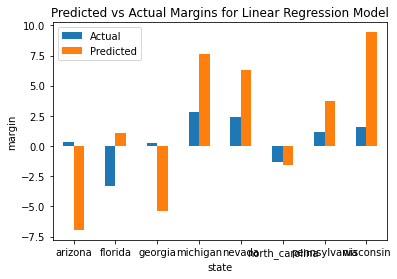

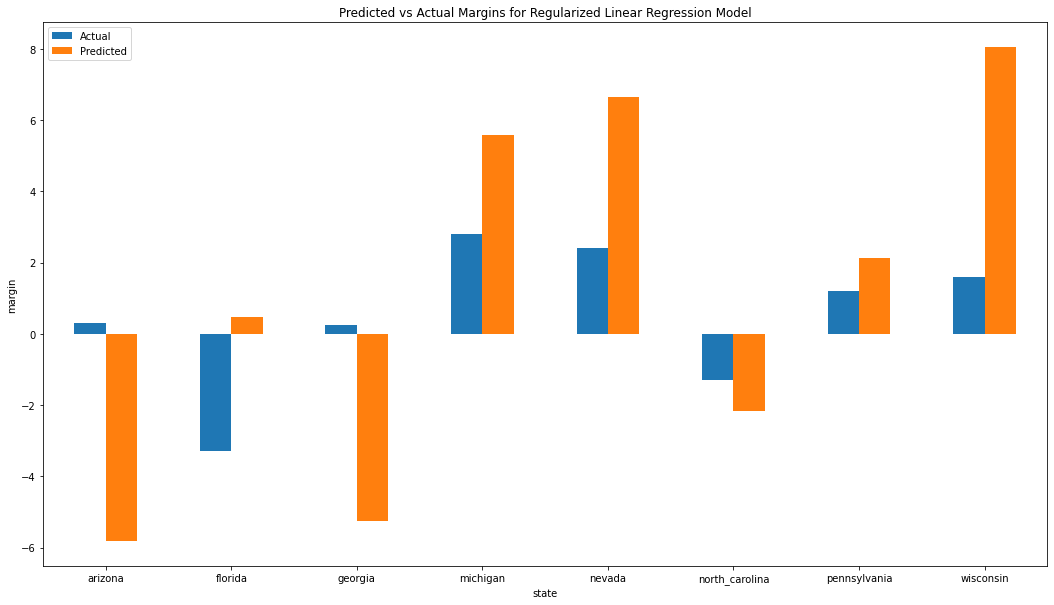

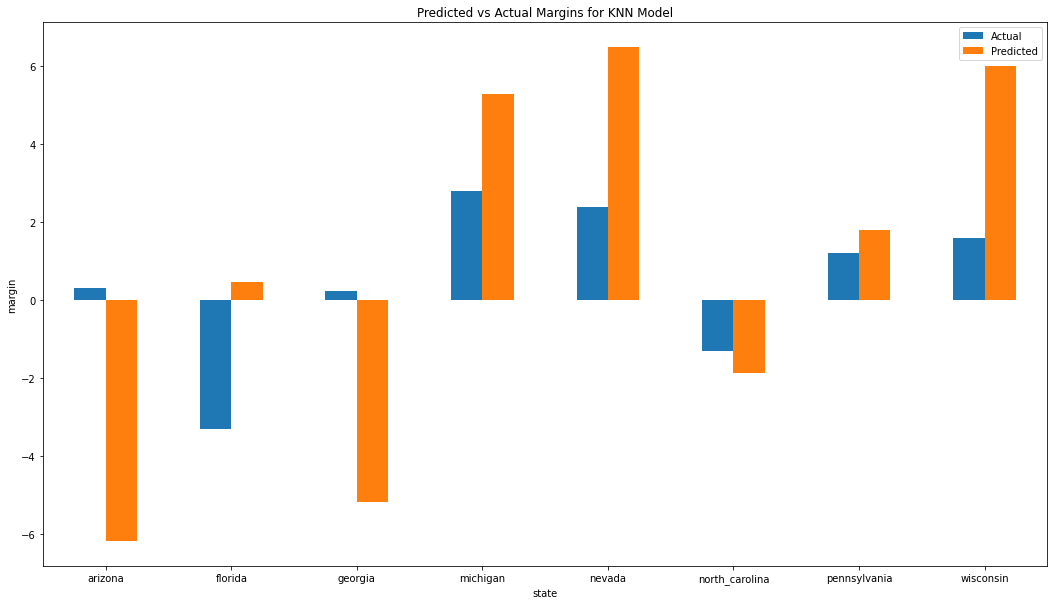

In [36]:
df_blah = model1_results[['state','actual_margin','predicted_margin']]
df_blah=df_blah.groupby('state').sum()
df1 = pd.DataFrame({'Actual': df_blah['actual_margin'],
                   'Predicted': df_blah['predicted_margin']})
df1.plot.bar(rot=0)

plt.title("Predicted vs Actual Margins for Linear Regression Model")
plt.xlabel("state")
plt.ylabel("margin")
plt.rcParams["figure.figsize"] = (18, 10)


df_blah2 = model2_results[['state','actual_margin','predicted_margin']]
df_blah2=df_blah2.groupby('state').sum()
df2 = pd.DataFrame({'Actual': df_blah2['actual_margin'],
                   'Predicted': df_blah2['predicted_margin']})
df2.plot.bar(rot=0)

plt.title("Predicted vs Actual Margins for Regularized Linear Regression Model")
plt.xlabel("state")
plt.ylabel("margin")
plt.rcParams["figure.figsize"] = (18,10)

df_blah3 = model3_results[['state','actual_margin','predicted_margin']]
df_blah3=df_blah3.groupby('state').sum()
df3 = pd.DataFrame({'Actual': df_blah3['actual_margin'],
                   'Predicted': df_blah3['predicted_margin']})
df3.plot.bar(rot=0)

plt.title("Predicted vs Actual Margins for KNN Model")
plt.xlabel("state")
plt.ylabel("margin")
plt.rcParams["figure.figsize"] = (18,10)

ANALYSIS

*While there seems to be some improvement with the KNN and regularized model, there does not seem to be a significant difference between the models. Ultimateley, Arizona is just way off, as are most of the states, yet at least the correct outcome (democrat vs. republican win) was predicted in 5 out of the 8. This election was much tighter than predicted and perhaps this is just a reflection of that.*

### Comparing MSE Scores

Since it was difficult to evaluate the difference in model efficacy using the above visualization, we will now compare MSE scores for each state using model instead.

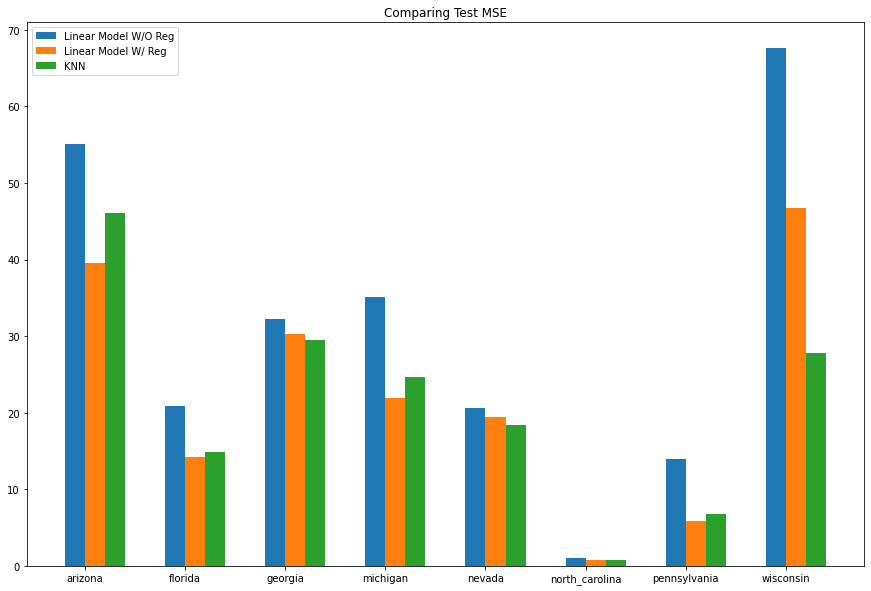

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
x = np.arange(len(model1_results.state))

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.2

# Note we add the `width` parameter now which sets the width of each bar.
ax.bar(x, model1_results['test_mse'], width=bar_width, label='Linear Model W/O Reg')

# Same thing, but offset the x by the width of the bar.
ax.bar(x + bar_width, model2_results['test_mse'],width=bar_width, label='Linear Model W/ Reg')
# Same thing, but offset the x by the width of the bar.
ax.bar(x + 2*bar_width, model3_results['test_mse'],width=bar_width, label='KNN')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model1_results.state)
ax.set_title('Comparing Test MSE')
ax.legend()

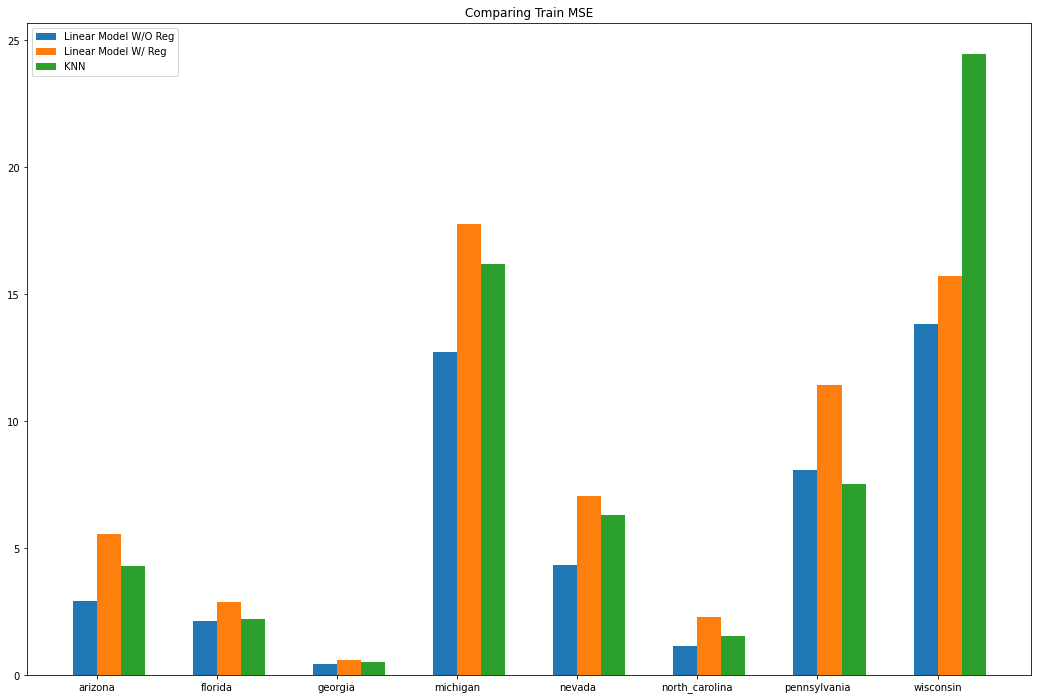

In [38]:
fig, ax = plt.subplots(figsize=(18, 12))
x = np.arange(len(model1_results.state))

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.2

# Note we add the `width` parameter now which sets the width of each bar.
ax.bar(x, model1_results['train_mse'], width=bar_width, label='Linear Model W/O Reg')

# Same thing, but offset the x by the width of the bar.
ax.bar(x + bar_width, model2_results['train_mse'],width=bar_width, label='Linear Model W/ Reg')
# Same thing, but offset the x by the width of the bar.
ax.bar(x + 2*bar_width, model3_results['train_mse'],width=bar_width, label='KNN')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model1_results.state)
ax.set_title('Comparing Train MSE')
ax.legend()

Based on these, visualizations, it is clear that KNN and regularization improves reduces the test MSE (which is what matters with our predictions). Though it increases the train MSE, we are not too worried as it is probably just being less biased and thus the train mse increases.  

In [39]:
# only considering top 3 predictors or something


#make sure it's clear that our model assumes everything else falls this way and nothing is gonna change
# results in this many electoral college votes
#maybe include years_to column?

In [40]:
election_margins_2020

,state,year,margin_perc
0,arizona,2020,0.30
1,florida,2020,-3.30
2,georgia,2020,0.24
3,michigan,2020,2.80
4,nevada,2020,2.40
5,north_carolina,2020,-1.30
6,pennsylvania,2020,1.20
7,wisconsin,2020,1.60
